# Uploading libraries

In [23]:
# Fundamental libraries

import os
import random
import time
import copy

# Working libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.autograd import Variable
from sklearn.metrics import classification_report
import torch.utils.data as data
import torchvision
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor, ViTForImageClassification, ViTConfig
import torchvision.transforms.functional as TF
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score
from importlib import reload
import utility
reload(utility)
from utility import load_data, plot_confusion_matrix, plot_average_f1_scores, train_model, get_classification_details, get_hard_disk_path, show_samples, plot_features_importance, visualize_correlation, get_shap

# Evaluation
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# FILE PATHS on local environment

#### Each folder path represent class (label) :

**Folder name - calss name : description**

0 - 0 class : dead

1 - 1 class : empty

2 - 2 class : keep0

3 - 3 class : keep1

4 - 4 class : keep2

5 - 5 class : reseed0

6 - 6 class : reseed1

7 -  7 class : split

In [24]:
# paths for data upload
FILE_PATH = get_hard_disk_path("DL_augmented")[:-1] + "_10/"
TRAIN_FEATURES_PATH_0 = FILE_PATH + 'dead' 
TRAIN_FEATURES_PATH_1 = FILE_PATH + 'empty'
TRAIN_FEATURES_PATH_2 = FILE_PATH + 'keep0'
TRAIN_FEATURES_PATH_3 = FILE_PATH + 'keep1'
TRAIN_FEATURES_PATH_4 = FILE_PATH + 'keep2'
TRAIN_FEATURES_PATH_5 = FILE_PATH + 'reseed0'
TRAIN_FEATURES_PATH_6 = FILE_PATH + 'reseed1'
TRAIN_FEATURES_PATH_7 = FILE_PATH + 'split'

# list with pathe
PATHES_LIST = [TRAIN_FEATURES_PATH_0,TRAIN_FEATURES_PATH_1,TRAIN_FEATURES_PATH_2,TRAIN_FEATURES_PATH_3,TRAIN_FEATURES_PATH_4, TRAIN_FEATURES_PATH_5, TRAIN_FEATURES_PATH_6, TRAIN_FEATURES_PATH_7]

Successfully loaded data from E:/data_for_DL_augmented/


# Data set : train & test

The data was divided into training and testing sets for each class, with a split of 80% for training and 20% for testing, maintaining the same ratio for each class. However, the dataset exhibits an imbalance issue, with one class having a significantly larger number of samples compared to the other class.

In [25]:
labels = ['dead', 'empty', 'keep0', 'keep1', 'keep2', 'reseed0', 'reseed1', 'split']
for i, path in enumerate(PATHES_LIST):
    print(path)
    print("Class ", labels[i], " : train : ",len(os.listdir(os.path.join(path, "train")))," test : ",len(os.listdir(os.path.join(path, "test"))))

E:/data_for_DL_augmented_10/dead
Class  dead  : train :  117  test :  4
E:/data_for_DL_augmented_10/empty
Class  empty  : train :  108  test :  3
E:/data_for_DL_augmented_10/keep0
Class  keep0  : train :  144  test :  5
E:/data_for_DL_augmented_10/keep1
Class  keep1  : train :  171  test :  5
E:/data_for_DL_augmented_10/keep2
Class  keep2  : train :  135  test :  4
E:/data_for_DL_augmented_10/reseed0
Class  reseed0  : train :  36  test :  2
E:/data_for_DL_augmented_10/reseed1
Class  reseed1  : train :  72  test :  2
E:/data_for_DL_augmented_10/split
Class  split  : train :  81  test :  3


### Customise test data set

The class `CustomImageDataset_test` is a custom dataset class used for testing or evaluating a machine learning model on a specific set of images. Here's a brief explanation of why it's needed:

1. **Path List**: The `path_list` parameter contains the list of paths to directories where the images are located. Each directory represents a different class or category.

2. **Transform**: The `transform` parameter represents the image transformations that need to be applied to each image, such as resizing, normalization, or augmentation.

3. **Ratio**: The `ratio` parameter determines the proportion of images that will be used for testing. It allows you to specify the desired split between the training and testing datasets.

4. **Initialization**: During initialization, the class calculates the size of each class based on the number of image files in the corresponding directory. It then determines the number of images to be included in the test set based on the specified ratio.

5. **Data Organization**: The class organizes the image paths and their corresponding labels, keeping only the images that will be used for testing. This ensures that the test dataset contains the desired proportion of samples from each class.

6. **Length and Indexing**: The `__len__` method returns the total number of images in the test set, while the `__getitem__` method allows indexing to retrieve a specific image and its label.

7. **Image Processing**: Within `__getitem__`, the class reads the image from the file path, converts it to a floating-point tensor, and applies the specified transformations. The image tensor and its corresponding label are then returned as a tuple.

By implementing this custom dataset class, you can easily load and process the test data in a standardized manner, making it convenient to evaluate the model's performance on a specific test set.

In [26]:
class CustomImageDataset_test(Dataset):
    def __init__(self, path_list, transform, ratio, model_name):
        self.path_list = path_list
        self.len = 0
        self.img_labels = []
        self.img_sort = []
        self.transform = transform
        self.processor = AutoImageProcessor.from_pretrained(model_name)  # Initialize the AutoImageProcessor

        for i, img_dir in enumerate(path_list):
            class_size = len([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
            class_size_test = round(class_size * (1 - ratio))
            self.len += class_size_test
            self.img_labels.extend([i] * class_size_test)
            self.img_sort.extend(sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".jpg")][-class_size_test:]))

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        img_path = self.img_sort[idx]
        image = read_image(img_path).float() / 255  # Loading the image and normalizing
        label = self.img_labels[idx]

        if self.transform:
            image = self.transform(image)

        # Process the image for the model using the AutoImageProcessor
        image = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        return image, label

### Customise train data set

The class `CustomImageDataset_train` is another custom dataset class specifically designed for training a machine learning model using augmented images. Here's a brief explanation of why it's needed, along with the rationale behind using data augmentation techniques:

1. **Path List**: Similar to the previous class, the `path_list` parameter contains the list of paths to directories where the training images are located.

2. **Transform**: The `transform` parameter represents the image transformations that need to be applied to each training image, such as resizing, normalization, or augmentation.

3. **Ratio**: The `ratio` parameter determines the proportion of images that will be used for training. It allows you to specify the desired split between the training and testing datasets.

4. **Initialization**: During initialization, the class calculates the size of each class based on the number of image files in the corresponding directory. It then determines the number of images to be included in the training set based on the specified ratio.

5. **Data Organization**: The class organizes the image paths and their corresponding labels, keeping only the images that will be used for training.

6. **Length and Indexing**: The `__len__` method returns the total number of images in the training set, while the `__getitem__` method allows indexing to retrieve a specific image and its label.

7. **Image Processing**: Within `__getitem__`, the class reads the image from the file path, converts it to a floating-point tensor, and applies the specified transformations. Additionally, the class applies data augmentation techniques to the training images to enhance the diversity and generalizability of the dataset.

8. **Augmentation Techniques**: The `augmentation` method implements several augmentation techniques commonly used for image data. These techniques include random cropping, random horizontal and vertical flipping, and rotation by a random angle between 0 and 45 degrees. By applying these techniques randomly to each training image, the dataset becomes more robust and less sensitive to variations in the input data.

The purpose of using data augmentation is to artificially increase the size and variability of the training dataset. This helps prevent overfitting and improves the model's ability to generalize to new, unseen data. By introducing random transformations during training, the model becomes more resilient to variations in the test data and can better handle real-world scenarios.

Overall, the `CustomImageDataset_train` class provides a convenient way to load, preprocess, and augment the training data, enabling effective training of machine learning models on a diverse and expanded dataset.

In [27]:
class CustomImageDataset_train(Dataset):
    def __init__(self, path_list, transform, ratio, model_name):
        self.path_list = path_list
        self.len = 0
        self.img_labels = []
        self.img_sort = []
        self.transform = transform
        self.processor = AutoImageProcessor.from_pretrained(model_name) # Initialize the AutoImageProcessor

        for i, img_dir in enumerate(path_list):
            class_size = len([f for f in sorted(os.listdir(img_dir)) if f.endswith(".jpg")])
            class_size_train = class_size - round(class_size * (1 - ratio))
            self.len += class_size_train
            self.img_labels.extend([i] * class_size_train)
            self.img_sort.extend(sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".jpg")])[:class_size_train])

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        img_path = self.img_sort[idx]
        image = read_image(img_path).float() / 255. # Loading the image and normalizing
        label = self.img_labels[idx]

        if self.transform:
            image = self.transform(image)

        image = self.augmentation(image) # Applying custom augmentation

        # Process the image for the model using the AutoImageProcessor
        image = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        return image, label
        
    def augmentation(self, image):
        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)

        # Random rotation by 0, 90, 180, or 270 degrees
        degree = random.choice([0, 90, 180, 270])
        image = TF.rotate(image, degree)

        return image

### Separate data to train and test data with ratio 0.8 in test data

To utilize the CustomImageDataset_test and CustomImageDataset_train, it is necessary to specify the desired transformations for each case, such as Normalize and CenterCrop.

The following code demonstrates how to define the transformations:

For test data transformation using CenterCrop:

In [28]:
class CustomImageDataset_test(Dataset):
    def __init__(self, path_list, transform=None, model_name=None):
        self.path_list = path_list
        self.transform = transform
        self.processor = None
        
        # Load the processor if a model name is given
        if model_name is not None:
            self.processor = AutoImageProcessor.from_pretrained(model_name)

        self.img_labels = []
        self.img_sort = []

        for i, img_dir in enumerate(path_list):
            # Load all images in the directory
            img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
            self.img_labels.extend([i] * len(img_files))
            self.img_sort.extend([os.path.join(img_dir, f) for f in img_files])

    def __len__(self):
        return len(self.img_sort)

    def __getitem__(self, idx):
        img_path = self.img_sort[idx]
        image = read_image(img_path).float()
        label = self.img_labels[idx]

        if image.shape[0] == 1:  # assuming (channel, height, width)
            image = image.repeat(3, 1, 1)

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Process the image for the model if a processor is available
        if self.processor:
            image = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        return image, label

In [29]:
train_path_list = [os.path.normpath(os.path.join(path,"train")) for path in PATHES_LIST]
test_path_list = [os.path.normpath(os.path.join(path,"test")) for path in PATHES_LIST]

In [30]:
print(train_path_list)

['E:\\data_for_DL_augmented_10\\dead\\train', 'E:\\data_for_DL_augmented_10\\empty\\train', 'E:\\data_for_DL_augmented_10\\keep0\\train', 'E:\\data_for_DL_augmented_10\\keep1\\train', 'E:\\data_for_DL_augmented_10\\keep2\\train', 'E:\\data_for_DL_augmented_10\\reseed0\\train', 'E:\\data_for_DL_augmented_10\\reseed1\\train', 'E:\\data_for_DL_augmented_10\\split\\train']


In [31]:
test_dataset = CustomImageDataset_test(path_list=test_path_list, 
                                  transform=None, 
                                  model_name='google/vit-base-patch16-224')

train_dataset = CustomImageDataset_test(path_list=train_path_list, 
                                  transform=None, 
                                  model_name='google/vit-base-patch16-224')

In [32]:
print(len(test_dataset), len(train_dataset))

28 864


In [33]:
model_name = "google/vit-base-patch16-224"
num_labels = len(labels)  # The number of unique labels/classes in your dataset

# Load the configuration of the model
config = ViTConfig.from_pretrained(model_name, num_labels=num_labels)

# Instantiate the model with the new configuration
model = ViTForImageClassification(config)

In [34]:
class ViTForImageClassificationWithAttention(ViTForImageClassification):
    """
    This class extends ViTForImageClassification to return attention weights.
    """
    
    def forward(self, pixel_values, output_attentions=True):
        outputs = self.vit(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
        )
        logits = self.classifier(outputs.last_hidden_state[:, 0])
        attention_weights = outputs.attentions if output_attentions else None
        return logits, attention_weights

# Replace the original ViT model with the modified one that returns attention weights
model = ViTForImageClassificationWithAttention(config)

In [38]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [39]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

Epoch 1, Train Loss: 0.1892994769981929, Validation Loss: 0.9400138258934021, Accuracy: 78.57142857142857 %
Class 0 F1 Score: 0.8
Class 1 F1 Score: 0.8
Class 2 F1 Score: 0.8000000000000002
Class 3 F1 Score: 0.7272727272727272
Class 4 F1 Score: 0.5714285714285715
Class 5 F1 Score: 1.0
Class 6 F1 Score: 1.0
Class 7 F1 Score: 0.8
Epoch 2, Train Loss: 0.07081851256745202, Validation Loss: 0.7431038618087769, Accuracy: 85.71428571428571 %
Class 0 F1 Score: 0.8
Class 1 F1 Score: 0.8
Class 2 F1 Score: 0.8000000000000002
Class 3 F1 Score: 0.8000000000000002
Class 4 F1 Score: 0.8571428571428571
Class 5 F1 Score: 1.0
Class 6 F1 Score: 1.0
Class 7 F1 Score: 1.0
Epoch 3, Train Loss: 0.036089830100536346, Validation Loss: 0.7792004942893982, Accuracy: 85.71428571428571 %
Class 0 F1 Score: 0.8
Class 1 F1 Score: 0.8
Class 2 F1 Score: 0.888888888888889
Class 3 F1 Score: 0.9090909090909091
Class 4 F1 Score: 0.75
Class 5 F1 Score: 1.0
Class 6 F1 Score: 1.0
Class 7 F1 Score: 0.8
Epoch 4, Train Loss: 0.01

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


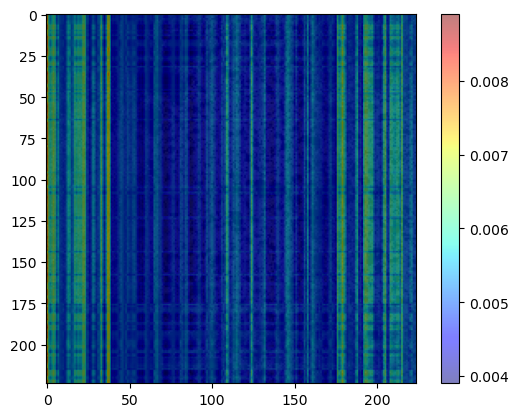

Epoch 20, Train Loss: 0.0010046490601130895, Validation Loss: 0.9452418088912964, Accuracy: 78.57142857142857 %
Class 0 F1 Score: 0.75
Class 1 F1 Score: 0.8
Class 2 F1 Score: 0.8000000000000002
Class 3 F1 Score: 0.7272727272727272
Class 4 F1 Score: 0.75
Class 5 F1 Score: 1.0
Class 6 F1 Score: 1.0
Class 7 F1 Score: 0.6666666666666666


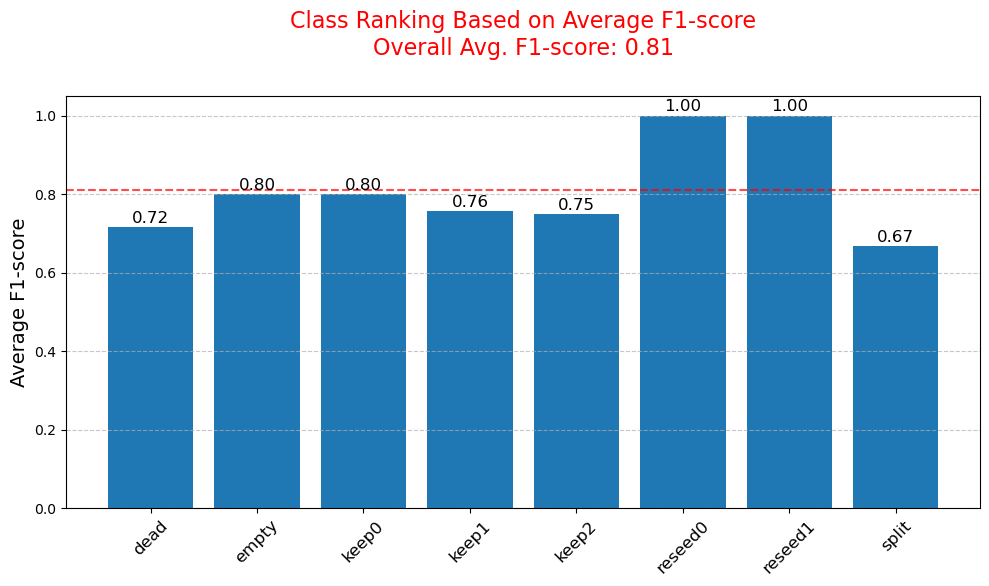

Finished Training


class_0_f1_score,▆▆▆▆▁▅▆▄▂▅▄▅██▄▄▅▄▅▅
class_1_f1_score,████████▁▁██████████
class_2_f1_score,▇▇█▇▇▆▇█▁▆▇▆▇▇▇▇▇▇▇▇
class_3_f1_score,▅▆█▆▅▄▆▇▁▄▆▃▄▄▆▆▅▆▅▅
class_4_f1_score,▃█▆▆▆██▃▆▁▆▃▅▅▆▆▆▆▆▆
class_5_f1_score,█████▆███▁█▆████████
class_6_f1_score,██████████▁█████████
class_7_f1_score,▇█▇▇▆▁█▆▇▁█▆██▆▆▆▆▆▆
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
final_accuracy,▁
train_loss,▇▃▂▁▁▃▂▂▆█▆▃▃▂▂▁▁▁▁▁


In [40]:
import torch
import wandb
from sklearn.metrics import f1_score

all_labels_list = ['dead', 'empty', 'keep0', 'keep1', 'keep2', 'reseed0', 'reseed1', 'split']

# Initialize a new wandb run
wandb.init(project="organoid_classification", entity="laurent-gurtler")

# Configurations (hyperparameters and model architecture)
config = wandb.config
config.learning_rate = 0.00001
config.batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

wandb.watch(model, criterion, log="all", log_freq=10)

epoch_f1_scores_dict_list = []

num_epochs = 20  # Number of epochs to train for

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Logging the training loss
    wandb.log({"epoch": epoch, "train_loss": running_loss/len(train_loader)})

    # Validation phase
    model.eval()
    all_labels = []
    all_predictions = []
    validation_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs, attention_weights = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            # Move the labels and predictions to CPU for sklearn metrics
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            last_layer_attention = attention_weights[-1]

            if epoch == num_epochs - 1:  # Example condition to visualize on the last epoch
                # Choose one sample to visualize, e.g., the first in the batch
                sample_attention_weights = attention_weights[-1][0]  # Last layer, first in batch
                sample_attention_map_cls = sample_attention_weights.mean(0)[1:]  # Ignore [CLS] token

                # Resize from (num_patches,) to (H, W) where H*W = num_patches
                attention_map_resized = cv2.resize(sample_attention_map_cls.cpu().numpy(), (224, 224), interpolation=cv2.INTER_CUBIC)

                # Overlay the attention map with the original image
                # Assuming the first image in the batch is transformed to have pixel values [0,1]
                original_image = images[0].cpu().numpy().transpose(1, 2, 0)
                plt.imshow(original_image)
                plt.imshow(attention_map_resized, cmap='jet', alpha=0.5)
                plt.colorbar()
                plt.show()

        # Now you might want to average across the heads, and ignore the class token:
        # Note: last_layer_attention[:, :, 0, 1:] has shape [32, num_heads, num_patches]
        attention_map = last_layer_attention.mean(dim=1)[:, 0, 1:].detach().cpu()
    
    # Calculate accuracy and F1 score
    accuracy = 100 * correct / total
    f1_scores = f1_score(all_labels, all_predictions, average=None, zero_division=0)  # This will give you an array of F1 scores per class
    f1_scores_dict = {f"{all_labels_list[idx]}": f1 for idx, f1 in enumerate(f1_scores)}
    epoch_f1_scores_dict_list.append(f1_scores_dict)

    # It might be useful to also get the classification report for all metrics
    classification_rep = classification_report(all_labels, all_predictions, output_dict=True, zero_division=0)

    # Logging the individual F1 scores
    for idx, f1 in enumerate(f1_scores):
        wandb.log({f"class_{idx}_f1_score": f1})

    # Logging the classification report
    wandb.log({"classification_report": classification_rep})

    wandb.log({"epoch": epoch, "validation_loss": validation_loss/len(test_loader)})

    # Print statistics for each class
    print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, "
        f"Validation Loss: {validation_loss/len(test_loader)}, Accuracy: {accuracy} %")
    for idx, f1 in enumerate(f1_scores):
        print(f"Class {idx} F1 Score: {f1}")

if len(epoch_f1_scores_dict_list) >= 5:
    # Get the last 5 epochs' F1-scores for each class
    last_5_epochs_f1_scores = epoch_f1_scores_dict_list[-5:]

    # Initialize a dictionary to hold the cumulative F1-scores for the last 5 epochs
    cumulative_f1_scores = {label: 0 for label in all_labels_list}

    # Sum the F1-scores for each label across the last 5 epochs
    for epoch_dict in last_5_epochs_f1_scores:
        for label, score in epoch_dict.items():
            cumulative_f1_scores[label] += score

    # Calculate the average F1-scores for each label
    average_f1_scores = {label: score / 5 for label, score in cumulative_f1_scores.items()}

    plot_average_f1_scores(all_labels_list, average_f1_scores)


# After the loop, you may want to log the overall performance
wandb.log({
    "final_accuracy": accuracy,
    "final_f1_scores": f1_scores.tolist(),  # Convert to list if necessary
    "final_classification_report": classification_rep
})

print('Finished Training')

# Close the wandb run
wandb.finish()
